# Simple PQ Implementation

In this notebook we will implement product quantization (PQ) using simple, readable, Python code.

In [1]:
x = [1, 8, 3, 9, 1, 2, 9, 4, 5, 4, 6, 2]

The first step is the creation of `m` subvectors:

In [2]:
m = 4
D = len(x)
# ensure D is divisable by m
assert D % m == 0
# length of each subvector will be D / m (D* in notation)
D_ = int(D / m)

In [5]:
# now create the subvectors
u = [x[row:row+D_] for row in range(0, D, D_)]
u

[[1, 8, 3], [9, 1, 2], [9, 4, 5], [4, 6, 2]]

Now we must create a set of clusters for each subvector space - giving us `m` seperate *codebooks* (codebook will map our subvectors to their assigned cluster centroids - *reproduction values*).

The clusters would usually be trained, we will not do that here as this example is using only one vector. We will use randomly generated centroid positions.

We need to decide how many centroids create - more centroids == lower error between vector positions and the centroids they are assigned to (more centroids increases the chances of vectors being assigned to a closer centroid).

This value is chosen by `k`, which must be divisable by `m` to create equal (sub)centroid ranges for each subvector.

In [30]:
k = 2**3
assert k % m == 0
k_ = int(k/m)
print(f"{k}, {k_}")

8, 2


We have `32` centroids in total, and `8` centroids per subvector space (subspace).

Each of these centroids will have three dimensions - aligned to our subvector dimensionality. Let's generate them.

In [31]:
from random import randint

c = []  # our overall list of reproduction values
for j in range(m):
    # each j represents a subvector (and therefore subquantizer) position
    c_j = []
    for i in range(k_):
        # each i represents a cluster/reproduction value position *inside* each subspace j
        c_ji = [randint(0, 9) for _ in range(D_)]
        c_j.append(c_ji)  # add cluster centroid to subspace list
    # add subspace list of centroids to overall list
    c.append(c_j)

In [32]:
c

[[[3, 7, 2], [5, 6, 7]],
 [[1, 2, 3], [7, 3, 0]],
 [[7, 5, 7], [5, 4, 8]],
 [[8, 4, 9], [8, 5, 2]]]

There are a lot of centroids in here so the easiest way for us to *see* them is to visualize:

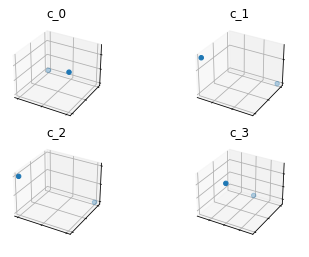

In [33]:
import matplotlib.pyplot as plt

fig = plt.figure()

for j in range(m):
    ax = fig.add_subplot(2, 2, j+1, projection='3d')
    # get centroid positions
    X = [c[j][i][0] for i in range(k_)]
    Y = [c[j][i][1] for i in range(k_)]
    Z = [c[j][i][2] for i in range(k_)]
    # plot
    ax.scatter(X, Y, Z)
    ax.set_title(f"c_{j}")
    # remove tick values (they're messy)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])

These are the centroids for each of our subspaces, subvector `u_0` will be mapped to a centroid within subspace `c_0`, `u_1` to `c_1`, etc, etc.

Let's go ahead and do this. First, we will define a function to find the nearest centroid using Euclidean distance.

In [34]:
def euclidean(v, u):
    distance = sum((x - y) ** 2 for x, y in zip(v, u)) ** .5
    return distance

def nearest(c_j, u_j):
    distance = 9e9
    for i in range(k_):
        new_dist = euclidean(c_j[i], u_j)
        if new_dist < distance:
            nearest_idx = i
            distance = new_dist
    return nearest_idx

And now we calculate the nearest centroids for each subspace.

In [35]:
ids = []
for j in range(m):
    i = nearest(c[j], u[j])
    ids.append(i)
ids

[0, 1, 0, 1]

Finally, we need a way to translate these IDs back into the centroid co-ordinates - well, we already have it - our codebook `c`, when it comes to comparing vectors we don't use the centroid IDs, we use the centroids themselves (our reproduction values).

In [39]:
q = []
for j in range(m):
    c_ji = c[j][ids[j]]
    q.extend(c_ji)

In [40]:
q

[3, 7, 2, 7, 3, 0, 7, 5, 7, 8, 5, 2]

We typical measure the error between our quantized vectors `q` and the originals `x` using mean squard error (MSE):

In [41]:
def mse(v, u):
    error = sum((x - y) ** 2 for x, y in zip(v, u)) / len(v)
    return error

In [42]:
mse(x, q)

3.6666666666666665

When using many vectors, we can to minimize the MSE over our original vectors and the centroids by increasing the number of centroids. However this will increase index size and so must be balanced.

Lower MSE == more accurate search results *and* higher memory usage.

---

# Search With PQ

Let's move onto building a *searchable* PQ index. For that we need more vectors - which we can get from the *Sift1M* dataset. We're still sticking with our unoptimized but readable implementation for now, so we will only use a small subset of these vectors.

In [48]:
from urllib.request import urlretrieve
import tarfile
# urlretrieve("ftp://ftp.irisa.fr/local/texmex/corpus/siftsmall.tar.gz", 'C:/Users/Sergey/Documents/GitHub/gpu-clusterize/faiss/data/siftsmall.tar.gz')

('C:/Users/Sergey/Documents/GitHub/gpu-clusterize/faiss/data/siftsmall.tar.gz',
 <email.message.Message at 0x224cc415828>)

In [54]:
import numpy as np

# now define a function to read the fvecs file format of Sift1M dataset
def read_fvecs(fp):
    a = np.fromfile(fp, dtype='int32')
    d = a[0]
    return a.reshape(-1, d + 1)[:, 1:].copy().view('float32')

# 1M samples originally, we stick with 1K
xb = read_fvecs(r'C:\Users\Sergey\Documents\GitHub\gpu-clusterize\faiss\data\siftsmall\siftsmall_base.fvecs')[:1000]
# queries
xq = read_fvecs(r'C:\Users\Sergey\Documents\GitHub\gpu-clusterize\faiss\data\siftsmall\siftsmall_query.fvecs')[0].reshape(1, -1)

In [55]:
xb.shape

(1000, 128)

In [56]:
xq.shape

(1, 128)

As before, we must create `m` subvectors (for each vector in `xb` this time).

In [57]:
m = 8
D = xb.shape[1]
assert D % m == 0
D_ = int(D/m)
D_

16

So we'll be working with subvectors with dimensionality `D_` of `16`. We must also set our `k` value, we will use a value of `2048` (or `2^11`) to leave us with `256` subquantizers (`k_`).

In [58]:
k = 2**11
assert k % m == 0
k_ = int(k/m)
k_

256

We can now create all of our centroids - we'll be doing this in Numpy this time so this will look slightly different, but the outcome is the same.

In [59]:
c = np.random.randint(1, int(xb.max()+1), (m, k_, D_))

In [60]:
c.shape

(8, 256, 16)

We now have `8` subspaces (set by `m`), each of these correspond to their respective subvector positions `j = 0 -> m`. Within each subspace we have `256` centroids/reproduction values (set by `k_`). Each of these centroids is a `16`-dimensional vector, equivalent to our subvector `u` dimensionalities (set by `D_`).

In [61]:
c[0].shape  # subspace 0, covering vector dims 0 -> 16

(256, 16)

In [62]:
c[1].shape  # subspace 1, covering vector dims 16 -> 32

(256, 16)

Our codebook `c` now contains a big list of all of our centroids, we use the index of each centroid as it's ID - and we will replace each of our datasets `xb` vectors with a sequence of it's nearest centroid IDs.

Because each vector is split into `m=8` subvectors, this means each vector can now be represented by `8` ID values.

Let's quantize our `xb` using this approach. First we need to split each `xb` vector `x` into subvectors `u` (or `ub` for the full set).

In [63]:
ub = xb.reshape(-1, m, D_)
ub.shape

(1000, 8, 16)

Then we loop through each subspace, identifying the nearest centroid positions for every single subvector.

In [64]:
id_b = np.zeros((xb.shape[0], m), dtype=np.uint8)
for row, u in enumerate(ub):
    for j in range(m):
        # get ID of nearest centroid within current 'j' subspace
        idx = nearest(c[j], u[j])
        id_b[row, j] = idx
id_b.shape

(1000, 8)

In [65]:
id_b[:5]

array([[187, 145, 158, 145, 136,   4,  36, 246],
       [ 21,  31, 213, 145, 136, 103,  36, 246],
       [187, 145, 158, 145, 136,   4,  36, 246],
       [131,  31, 158, 123, 136,  54,  82, 246],
       [ 39, 145, 158, 145,  68,  42,  36, 246]], dtype=uint8)

We've now converted our vectors into quantized vectors where each 16-dimensional subvector can be represented by a single 8-bit integer. This also has the bonus effect of reducing vector dimensionality from *128 -> 8*.

Now, these IDs cannot be used when comparing the distance between a query vector `xq` and the data `id_b` - instead we use the *codebook* `c` to map the subvector IDs in `id_b` to their respective subvector centroids - which we then compare to the equivalent `xq` subvectors.

Let's go ahead and do that. First, we create a subvector version of our query vector `xq`.

In [66]:
uq = xq.reshape(m, D_)
uq.shape

(8, 16)

And now we compare this to all of our quantized subvector values (the centroids), which we map using our codebook `c` and ID vectors in `id_b`.

We can extract these quantized subvectors like so:

In [67]:
j = 2  # subspace 2
row = 5  # row/sample 5 in our data
c[j][id_b[row][j]]

array([155,  71,   5,  21,  68, 100,  23, 114, 122,  19,  17,  27,  32,
       104,  39,  38])

That's a single quantized subvector, we will loop through and do this for all - and calculate the Euclidean distance with `np.linalg.norm` for *every* subvector - summing them all to get a final value (which does not represent the 'estimated' distance between them).

In [138]:
all_dist = []
# we will loop through each ID vector in qb
for row in range(id_b.shape[0]):
    u_dist = 0  # we use this to store all subvector distances
    for j in range(m):
        # get the quantized subvec value of qb[b]
        qb_j = c[j][id_b[row][j]]
        # calculate the distance between query subvec and quantized db vec
        u_dist += np.linalg.norm(uq[j] - qb_j)
    # add total distance between query subvecs and qb subvecs
    all_dist.append((u_dist, row))


In [139]:
all_dist[:5]

[(1892.7344888809694, 0),
 (1941.992068055266, 1),
 (1895.864167006609, 2),
 (1996.9471078170002, 3),
 (1942.1256710923853, 4)]

In [140]:
all_dist.sort()
all_dist[:5]

[(1532.1243596980867, 408),
 (1535.5973447572023, 598),
 (1542.6889938766724, 643),
 (1552.2655535367062, 270),
 (1552.5498689085962, 870)]

Now we have our nearest neighbors. The top five closest, according to our PQ method are `408`, `598`, `643`, `270`, and `870`. Let's compare the original vectors using Euclidean distance to see if these vectors are genuinely closer to our query vector `xq` than other vectors in `xb`.

In [164]:
# this is our average distance between all vectors
np.mean(np.linalg.norm(xb - xq, axis=1))

524.0475

In [176]:
# and our distances for the top 15...
for dist, idx in all_dist[:15]:
    print(f"{idx}: {np.linalg.norm(xb[idx] - xq)}")

408: 382.0392761230469
598: 334.31719970703125
643: 370.2404479980469
270: 370.43218994140625
870: 373.1098937988281
292: 314.4996032714844
756: 364.95343017578125
172: 365.80596923828125
924: 340.1264343261719
610: 388.8958740234375
779: 379.72491455078125
210: 395.8926696777344
762: 369.0989074707031
882: 282.3154296875
467: 406.41357421875


We are returning much lower values than the average - but how close are these to the true lowest distances?

In [177]:
dist_arr = np.linalg.norm(xb - xq, axis=1)
# get smallest
true_lowest = np.argsort(dist_arr)[:15]
# get previous IDs of lowest values using our PQ
prev_idx = [x[1] for x in all_dist[:15]]
for true_idx in true_lowest:
    print(f"{true_idx}: {round(dist_arr[true_idx], 2)} | {true_idx in prev_idx}")

882: 282.32000732421875 | True
190: 292.94000244140625 | False
816: 311.0299987792969 | False
224: 313.8399963378906 | False
292: 314.5 | True
492: 321.8500061035156 | False
146: 326.5299987792969 | False
107: 326.80999755859375 | False
641: 331.0400085449219 | False
598: 334.32000732421875 | True
370: 334.5 | False
121: 334.9800109863281 | False
124: 336.5 | False
696: 337.1300048828125 | False
924: 340.1300048828125 | True


So out of the top *15* we have return *4* matches - it's not bad, but not great - which should be expected, we're working with a very basic implementation, we have not trained our clusters, and PQ by itself focuses on reducing memory usage rather than anything else. So all things considered, 4/15 is a reasonable result.

In [178]:
xb.min()

0.0

In [179]:
xb.max()

157.0